In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split

# Define the autoencoder
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(200, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 16)
        )
        self.decoder = nn.Sequential(
            nn.Linear(16, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 200),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Instantiate the model
model = Autoencoder()

# Load and preprocess data
X_train = np.load('train_data.npy')
X_anomaly = np.load('anomaly_data.npy')

mean_ = X_train.mean(0).mean(0).reshape(1, 1, 2)
std_ = X_train.std(1).mean(0).reshape(1, 1, 2)
X_train -= mean_
X_train /= std_
X_anomaly -= mean_
X_anomaly /= std_

X_tensor_train = torch.tensor(X_train, dtype=torch.float32).permute(0, 2, 1).flatten(1)
X_tensor_anomaly = torch.tensor(X_anomaly, dtype=torch.float32).permute(0, 2, 1).flatten(1)

# Create a dataset
dataset = TensorDataset(X_tensor_anomaly, X_tensor_anomaly)

# Split the dataset into training and validation sets (e.g., 80% train, 20% validation)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=2048, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2048, shuffle=False)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 50
best_val_loss = float('inf')  # To track the best validation loss

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    for data in train_loader:
        inputs, _ = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            inputs, _ = data
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            val_loss += loss.item()

    # Average losses for the epoch
    train_loss /= len(train_loader)
    val_loss /= len(val_loader)

    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

    # Save the model if the validation loss is the best we've seen so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'model.pth')
        print(f'Model saved at epoch {epoch + 1} with validation loss {val_loss:.4f}')

Epoch 1/50, Train Loss: 996.8259, Validation Loss: 271.3429
Model saved at epoch 1 with validation loss 271.3429
Epoch 2/50, Train Loss: 156.8820, Validation Loss: 67.5691
Model saved at epoch 2 with validation loss 67.5691
Epoch 3/50, Train Loss: 36.5161, Validation Loss: 21.3231
Model saved at epoch 3 with validation loss 21.3231
Epoch 4/50, Train Loss: 17.1016, Validation Loss: 14.1636
Model saved at epoch 4 with validation loss 14.1636
Epoch 5/50, Train Loss: 13.0790, Validation Loss: 12.0380
Model saved at epoch 5 with validation loss 12.0380
Epoch 6/50, Train Loss: 11.8063, Validation Loss: 11.4647
Model saved at epoch 6 with validation loss 11.4647
Epoch 7/50, Train Loss: 11.5110, Validation Loss: 11.3227
Model saved at epoch 7 with validation loss 11.3227
Epoch 8/50, Train Loss: 11.4023, Validation Loss: 11.2457
Model saved at epoch 8 with validation loss 11.2457
Epoch 9/50, Train Loss: 11.3368, Validation Loss: 11.1798
Model saved at epoch 9 with validation loss 11.1798
Epoch 

In [2]:
mean_,std_

(array([[[14.99986662, 46.95354183]]]),
 array([[[2.99375461e-05, 1.97048753e-05]]]))

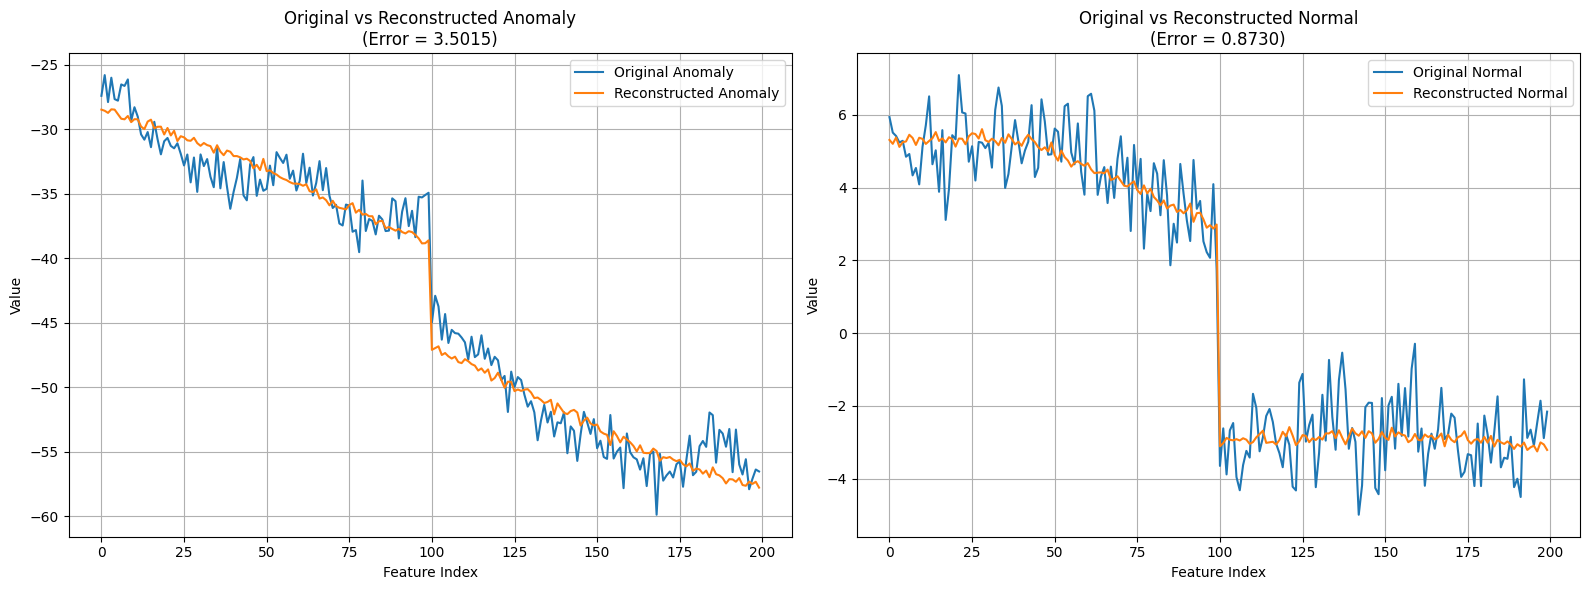

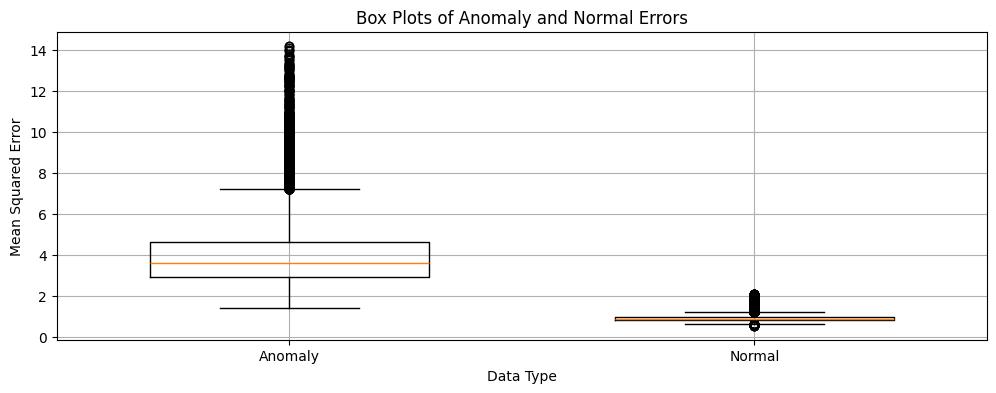

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Generate the output and errors for anomalies
X_tensor_anomaly_output = model(X_tensor_anomaly)
error_anomaly = ((X_tensor_anomaly - X_tensor_anomaly_output) ** 2).mean(1)

# Generate the output and errors for normal data
X_tensor_train_output = model(X_tensor_train)
error_normal = ((X_tensor_train_output - X_tensor_train) ** 2).mean(1)

# Randomly select samples for anomaly and normal
i_anomaly = np.random.randint(X_tensor_anomaly.shape[0])
i_normal = np.random.randint(X_tensor_train.shape[0])

# Create a figure with 2 subplots side by side
plt.figure(figsize=(16, 6))

# Plot the original and reconstructed anomaly sample
plt.subplot(1, 2, 1)
plt.plot(X_tensor_anomaly[i_anomaly].detach().numpy(), label='Original Anomaly')
plt.plot(X_tensor_anomaly_output[i_anomaly].detach().numpy(), label='Reconstructed Anomaly')
plt.title(f'Original vs Reconstructed Anomaly\n(Error = {error_anomaly[i_anomaly]:.4f})')
plt.xlabel('Feature Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

# Plot the original and reconstructed normal sample
plt.subplot(1, 2, 2)
plt.plot(X_tensor_train[i_normal].detach().numpy(), label='Original Normal')
plt.plot(X_tensor_train_output[i_normal].detach().numpy(), label='Reconstructed Normal')
plt.title(f'Original vs Reconstructed Normal\n(Error = {error_normal[i_normal]:.4f})')
plt.xlabel('Feature Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

# Show the plots
plt.tight_layout()
plt.show()

# Plot box plots for error distributions
plt.figure(figsize=(12, 4))
plt.boxplot([error_anomaly.detach().numpy(), error_normal.detach().numpy()], 
            positions=[1, 2], widths=0.6)
plt.title('Box Plots of Anomaly and Normal Errors')
plt.xlabel('Data Type')
plt.ylabel('Mean Squared Error')
plt.xticks([1, 2], ['Anomaly', 'Normal'])
plt.grid(True)
plt.show()